In [1]:
# Core data libraries
import pandas as pd
import numpy as np

# Visualization (we will use later)
import matplotlib.pyplot as plt

# Display settings for readability
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

# Notebook metadata
print("Environment ready")


Environment ready


In [2]:
# Load main mortgage data
data_path = "data/33100530.csv"
meta_path = "data/33100530_MetaData.csv"

df = pd.read_csv(data_path)
meta = pd.read_csv(meta_path)

# Basic sanity checks
print("Main data shape:", df.shape)
print("Metadata shape:", meta.shape)

# Preview first few rows
df.head()


Main data shape: (11133, 17)
Metadata shape: (113, 10)


,REF_DATE,GEO,DGUID,Lender type,Characteristics of outstanding residential mortgage loans,Residential mortgage loans outstanding,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2020-01,Canada,2021A000011124,All non-bank lenders,Total outstanding residential mortgages,Value of mortgages outstanding,Dollars,81,thousands,3,v1374992054,1.1.1.1,"330,340,738.00",NaN,NaN,NaN,0
1,2020-01,Canada,2021A000011124,All non-bank lenders,Total outstanding residential mortgages,Number of mortgages outstanding,Number,223,units,0,v1374992294,1.1.1.2,"1,698,803.00",NaN,NaN,NaN,0
2,2020-01,Canada,2021A000011124,All non-bank lenders,Total insured outstanding residential mortgages,Value of mortgages outstanding,Dollars,81,thousands,3,v1374992055,1.1.2.1,"133,557,822.00",NaN,NaN,NaN,0
3,2020-01,Canada,2021A000011124,All non-bank lenders,Total insured outstanding residential mortgages,Number of mortgages outstanding,Number,223,units,0,v1374992295,1.1.2.2,"586,950.00",NaN,NaN,NaN,0
4,2020-01,Canada,2021A000011124,All non-bank lenders,Total uninsured outstanding residential mortgages,Value of mortgages outstanding,Dollars,81,thousands,3,v1374992056,1.1.3.1,"196,782,916.00",NaN,NaN,NaN,0


In [3]:
# Show column names
print("Columns in main dataset:")
for col in df.columns:
    print("-", col)

print("\nData types:")
df.dtypes


Columns in main dataset:
- REF_DATE
- GEO
- DGUID
- Lender type
- Characteristics of outstanding residential mortgage loans
- Residential mortgage loans outstanding
- UOM
- UOM_ID
- SCALAR_FACTOR
- SCALAR_ID
- VECTOR
- COORDINATE
- VALUE
- STATUS
- SYMBOL
- TERMINATED
- DECIMALS

Data types:


REF_DATE                                                      object
GEO                                                           object
DGUID                                                         object
Lender type                                                   object
Characteristics of outstanding residential mortgage loans     object
Residential mortgage loans outstanding                        object
UOM                                                           object
UOM_ID                                                         int64
SCALAR_FACTOR                                                 object
SCALAR_ID                                                      int64
VECTOR                                                        object
COORDINATE                                                    object
VALUE                                                        float64
STATUS                                                        object
SYMBOL                            

In [4]:
# --- Parse date column ---
df["REF_DATE"] = pd.to_datetime(df["REF_DATE"])

# --- Filter to Canada ---
df_canada = df[df["GEO"] == "Canada"].copy()

# --- Filter to non-bank lenders ---
df_nonbank = df_canada[df_canada["Lender type"] == "Non-bank"].copy()

# --- Keep only insured and uninsured residential mortgages ---
df_nonbank = df_nonbank[
    df_nonbank["Characteristics of outstanding residential mortgage loans"]
    .isin(["Insured", "Uninsured"])
].copy()

# --- Select relevant columns ---
df_clean = df_nonbank[[
    "REF_DATE",
    "Characteristics of outstanding residential mortgage loans",
    "VALUE"
]].rename(columns={
    "REF_DATE": "date",
    "Characteristics of outstanding residential mortgage loans": "insurance_status",
    "VALUE": "mortgage_value"
})

# --- Sort by time ---
df_clean = df_clean.sort_values("date")

# --- Basic validation ---
print("Clean dataset shape:", df_clean.shape)
print("\nInsurance status counts:")
print(df_clean["insurance_status"].value_counts())

df_clean.head()


Clean dataset shape: (0, 3)

Insurance status counts:
Series([], Name: count, dtype: int64)


,date,insurance_status,mortgage_value


In [5]:
# Inspect unique values for mortgage characteristics
df_nonbank_check = df[
    (df["GEO"] == "Canada") &
    (df["Lender type"] == "Non-bank")
]

df_nonbank_check[
    "Characteristics of outstanding residential mortgage loans"
].value_counts()


Series([], Name: count, dtype: int64)

In [6]:
# Inspect all lender type categories available for Canada
df[df["GEO"] == "Canada"]["Lender type"].value_counts()


Lender type
All non-bank lenders                                                2760
Credit Unions                                                       2760
Mortgage Investment Entities                                        2760
Other types of non-bank lenders                                     2760
Mortgage Investment Entities and Other types of non-bank lenders       3
Name: count, dtype: int64

In [7]:
# --- Parse date column ---
df["REF_DATE"] = pd.to_datetime(df["REF_DATE"])

# --- Filter to Canada ---
df_canada = df[df["GEO"] == "Canada"].copy()

# --- Filter to all non-bank lenders ---
df_nonbank = df_canada[
    df_canada["Lender type"] == "All non-bank lenders"
].copy()

print("Non-bank dataset shape:", df_nonbank.shape)

# --- Inspect insurance-status labels (very important) ---
df_nonbank[
    "Characteristics of outstanding residential mortgage loans"
].value_counts()


Non-bank dataset shape: (2760, 17)


Characteristics of outstanding residential mortgage loans
Total outstanding residential mortgages                                                                      46
Total insured outstanding residential mortgages                                                              46
More than 50% and up to 55%, uninsured outstanding residential mortgages by TDS ratio                        46
More than 55% and up to 60%, uninsured outstanding residential mortgages by TDS ratio                        46
More than 60%, uninsured outstanding residential mortgages by TDS ratio                                      46
Total insured outstanding residential mortgages by loan-to-value (LTV) ratio                                 46
65% or less, insured outstanding residential mortgages by LTV ratio                                          46
More than 65% and up to 75%, insured outstanding residential mortgages by LTV ratio                          46
More than 75% and up to 80%, insured outstandi

In [8]:
# --- Keep only total insured and total uninsured series ---
df_totals = df_nonbank[
    df_nonbank["Characteristics of outstanding residential mortgage loans"].isin([
        "Total insured outstanding residential mortgages",
        "Total uninsured outstanding residential mortgages by loan-to-value (LTV) ratio"
    ])
].copy()

# --- Pivot to wide format ---
df_pivot = df_totals.pivot_table(
    index="REF_DATE",
    columns="Characteristics of outstanding residential mortgage loans",
    values="VALUE"
).reset_index()

# --- Rename columns for clarity ---
df_pivot = df_pivot.rename(columns={
    "REF_DATE": "date",
    "Total insured outstanding residential mortgages": "insured",
    "Total uninsured outstanding residential mortgages by loan-to-value (LTV) ratio": "uninsured"
})

# --- Construct risk metrics ---
df_pivot["total_mortgages"] = df_pivot["insured"] + df_pivot["uninsured"]
df_pivot["uninsured_share"] = df_pivot["uninsured"] / df_pivot["total_mortgages"]
df_pivot["insured_share"] = df_pivot["insured"] / df_pivot["total_mortgages"]

# --- Sort by time ---
df_pivot = df_pivot.sort_values("date")

# --- Validation ---
print("Final dataset shape:", df_pivot.shape)
df_pivot.head()


Final dataset shape: (23, 6)


Characteristics of outstanding residential mortgage loans,date,insured,uninsured,total_mortgages,uninsured_share,insured_share
0,2020-01-01,"67,072,386.00","98,947,384.50","166,019,770.50",0.60,0.40
1,2020-04-01,"67,705,830.00","98,653,913.50","166,359,743.50",0.59,0.41
2,2020-07-01,"68,290,078.00","101,603,481.50","169,893,559.50",0.60,0.40
3,2020-10-01,"67,282,015.50","102,352,546.00","169,634,561.50",0.60,0.40
4,2021-01-01,"65,699,824.00","104,597,766.00","170,297,590.00",0.61,0.39


In [9]:
# --- Create period identifiers ---
df_pivot["year"] = df_pivot["date"].dt.year
df_pivot["quarter"] = df_pivot["date"].dt.to_period("Q")

# --- Calculate quarter-over-quarter growth rates ---
df_pivot["insured_qoq_growth"] = df_pivot["insured"].pct_change()
df_pivot["uninsured_qoq_growth"] = df_pivot["uninsured"].pct_change()
df_pivot["total_qoq_growth"] = df_pivot["total_mortgages"].pct_change()

# --- Define COVID periods ---
df_pivot["period"] = np.where(
    df_pivot["date"] < pd.Timestamp("2020-03-01"),
    "Pre-COVID",
    "Post-COVID"
)

# --- Quick validation ---
df_pivot[[
    "date",
    "insured_qoq_growth",
    "uninsured_qoq_growth",
    "period"
]].head(8)


Characteristics of outstanding residential mortgage loans,date,insured_qoq_growth,uninsured_qoq_growth,period
0,2020-01-01,NaN,NaN,Pre-COVID
1,2020-04-01,0.01,-0.00,Post-COVID
2,2020-07-01,0.01,0.03,Post-COVID
3,2020-10-01,-0.01,0.01,Post-COVID
4,2021-01-01,-0.02,0.02,Post-COVID
5,2021-04-01,-0.01,0.04,Post-COVID
6,2021-07-01,-0.02,0.03,Post-COVID
7,2021-10-01,-0.01,0.03,Post-COVID


In [10]:
# --- Pre vs Post COVID summary ---
comparison_table = df_pivot.groupby("period").agg(
    avg_insured_growth=("insured_qoq_growth", "mean"),
    avg_uninsured_growth=("uninsured_qoq_growth", "mean"),
    avg_uninsured_share=("uninsured_share", "mean"),
    total_periods=("date", "count")
).reset_index()

comparison_table


,period,avg_insured_growth,avg_uninsured_growth,avg_uninsured_share,total_periods
0,Post-COVID,0.00,0.02,0.65,22
1,Pre-COVID,NaN,NaN,0.60,1


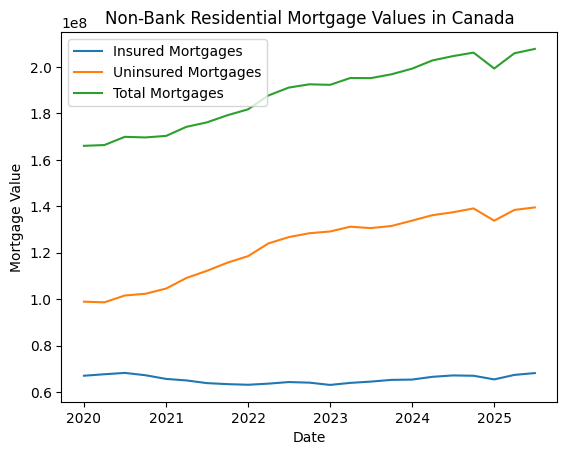

In [11]:
plt.figure()
plt.plot(df_pivot["date"], df_pivot["insured"], label="Insured Mortgages")
plt.plot(df_pivot["date"], df_pivot["uninsured"], label="Uninsured Mortgages")
plt.plot(df_pivot["date"], df_pivot["total_mortgages"], label="Total Mortgages")

plt.title("Non-Bank Residential Mortgage Values in Canada")
plt.xlabel("Date")
plt.ylabel("Mortgage Value")
plt.legend()
plt.show()


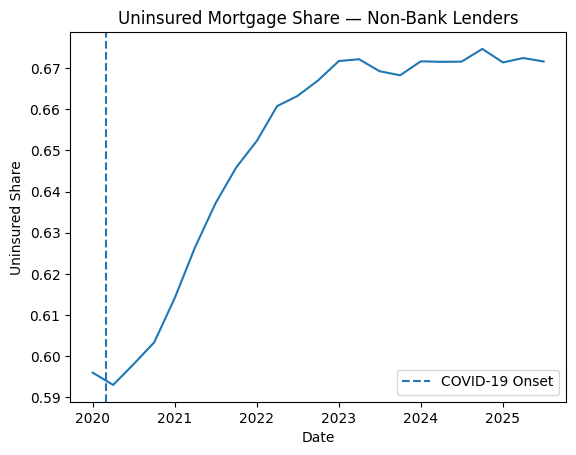

In [12]:
plt.figure()
plt.plot(df_pivot["date"], df_pivot["uninsured_share"])

plt.axvline(pd.Timestamp("2020-03-01"), linestyle="--", label="COVID-19 Onset")

plt.title("Uninsured Mortgage Share — Non-Bank Lenders")
plt.xlabel("Date")
plt.ylabel("Uninsured Share")
plt.legend()
plt.show()


In [14]:
volatility_table = df_pivot.groupby("period").agg(
    insured_growth_volatility=("insured_qoq_growth", "std"),
    uninsured_growth_volatility=("uninsured_qoq_growth", "std")
).reset_index()

volatility_table


,period,insured_growth_volatility,uninsured_growth_volatility
0,Post-COVID,0.01,0.02
1,Pre-COVID,NaN,NaN


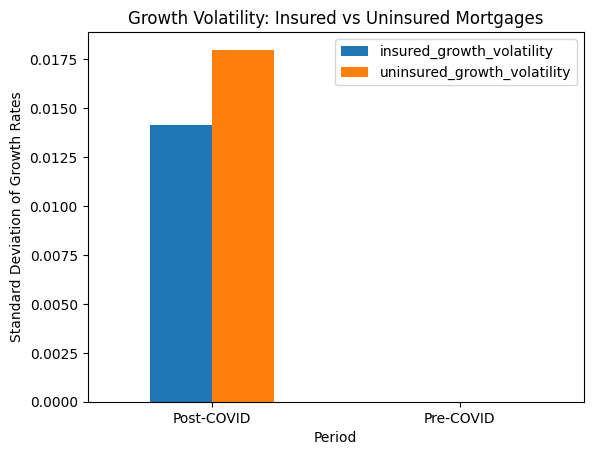

In [15]:
# Prepare data for plotting
vol_data = volatility_table.set_index("period")

# Plot
vol_data.plot(kind="bar")
plt.title("Growth Volatility: Insured vs Uninsured Mortgages")
plt.ylabel("Standard Deviation of Growth Rates")
plt.xlabel("Period")
plt.xticks(rotation=0)
plt.show()
